# Train Teacher Model (YOLOv11-L) for Knowledge Distillation

This step trains a high-capacity teacher model (YOLOv11-L) that will later be used to guide a smaller student model through Knowledge Distillation (KD).
The teacher model should achieve strong feature representation and high mAP, because the quality of the distilled student model depends on how well the teacher has learned.

Key Goals:

- Achieve high mAP50 and mAP50-95

- Ensure the model converges fully (no early stop plateau)

- Produce a stable and generalizable checkpoint (best.pt) to be used for KD

Training Notes:

- best.pt selected based on validation performance, not final epoch

Epochs: 100 depending on dataset complexity (100 random picture in more than 3000 multi-traffic-view picture)

After training completes, we will proceed to:

- Distillation Round 1: YOLOv11-L → YOLOv11-N

- Optional Compression: Pruning + Ghost layers + INT8 Quantization for deployment on Raspberry Pi 4
- Distillation Round 2: Optional Compression + new YOLOv11-L with new training dataset- improve mAP
- Goals: mAP YOLOv11n ~ 3-6% YOLOv11l

In [ ]:
!nvidia-smi
!pip install ultralytics==8.3.213
!pip install roboflow
!pip install ultralytics==8.3.213 matplotlib seaborn
!nvidia-smi
import matplotlib.pyplot as plt
import seaborn as sns

# prepare model

Sat Oct 25 09:42:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Derection dataset_folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Đường dẫn dataset trong Drive (nơi có data.yaml, train/, val/)
DATASET_DIR = "/content/drive/MyDrive/multi_traffic_dataset/multi_view_traffic/split_yolo"

# Đường dẫn project (nơi YOLO lưu kết quả train)
PROJECT_DIR = "/content/drive/MyDrive/yolo_traffic_v11"

!mkdir -p {PROJECT_DIR}
%cd {PROJECT_DIR}


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/yolo_traffic_v11


In [ ]:
import os, random, shutil
#this function used to decision dataset (100pic)
SRC_IMG = "/content/drive/MyDrive/multi_traffic_dataset/multi_view_traffic/split_yolo/train/images"
SRC_LAB = "/content/drive/MyDrive/multi_traffic_dataset/multi_view_traffic/split_yolo/train/labels"

DEST_BASE = "/content/drive/MyDrive/multi_traffic_dataset/multi_view_traffic/test_100"
DEST_IMG = f"{DEST_BASE}/images"
DEST_LAB = f"{DEST_BASE}/labels"

os.makedirs(DEST_IMG, exist_ok=True)
os.makedirs(DEST_LAB, exist_ok=True)

files = [f for f in os.listdir(SRC_IMG) if f.endswith(('.jpg', '.png'))]
k = min(100, len(files))
sample = random.sample(files, k)

for f in sample:
    src_img = os.path.join(SRC_IMG, f)
    src_lab = os.path.join(SRC_LAB, os.path.splitext(f)[0] + ".txt")

    if os.path.exists(src_img):
        shutil.copy(src_img, DEST_IMG)
    if os.path.exists(src_lab):
        shutil.copy(src_lab, DEST_LAB)

print(f" Copied {len(sample)} images and labels to {DEST_BASE}")


 Copied 100 images and labels to /content/drive/MyDrive/multi_traffic_dataset/multi_view_traffic/test_100


# Transfer data at the same level

In [ ]:
"""
import os, shutil

# ====== TRAIN ======
train_images = "/content/drive/MyDrive/multi_traffic_dataset/multi_view_traffic/split_yolo/train/images"
train_labels = "/content/drive/MyDrive/multi_traffic_dataset/multi_view_traffic/split_yolo/train/labels"

for sub in ["drone_images", "infrastructure_images"]:
    src = os.path.join(train_images, sub)
    if os.path.exists(src):
        for f in os.listdir(src):
            if f.endswith(('.jpg', '.png')):
                shutil.move(os.path.join(src, f), train_images)
        os.rmdir(src)
    src_lab = os.path.join(train_labels, sub.replace("images", "labels"))
    if os.path.exists(src_lab):
        for f in os.listdir(src_lab):
            if f.endswith(".txt"):
                shutil.move(os.path.join(src_lab, f), train_labels)
        os.rmdir(src_lab)

# ====== VAL ======
val_images = "/content/drive/MyDrive/multi_traffic_dataset/multi_view_traffic/split_yolo/val/images"
val_labels = "/content/drive/MyDrive/multi_traffic_dataset/multi_view_traffic/split_yolo/val/labels"

for sub in ["drone_images", "infrastructure_images"]:
    src = os.path.join(val_images, sub)
    if os.path.exists(src):
        for f in os.listdir(src):
            if f.endswith(('.jpg', '.png')):
                shutil.move(os.path.join(src, f), val_images)
        os.rmdir(src)
    src_lab = os.path.join(val_labels, sub.replace("images", "labels"))
    if os.path.exists(src_lab):
        for f in os.listdir(src_lab):
            if f.endswith(".txt"):
                shutil.move(os.path.join(src_lab, f), val_labels)
        os.rmdir(src_lab)

print("✅ Gộp ảnh & label về cùng cấp thành công.")
"""


'\nimport os, shutil\n\n# ====== TRAIN ======\ntrain_images = "/content/drive/MyDrive/multi_traffic_dataset/multi_view_traffic/split_yolo/train/images"\ntrain_labels = "/content/drive/MyDrive/multi_traffic_dataset/multi_view_traffic/split_yolo/train/labels"\n\nfor sub in ["drone_images", "infrastructure_images"]:\n    src = os.path.join(train_images, sub)\n    if os.path.exists(src):\n        for f in os.listdir(src):\n            if f.endswith((\'.jpg\', \'.png\')):\n                shutil.move(os.path.join(src, f), train_images)\n        os.rmdir(src)\n    src_lab = os.path.join(train_labels, sub.replace("images", "labels"))\n    if os.path.exists(src_lab):\n        for f in os.listdir(src_lab):\n            if f.endswith(".txt"):\n                shutil.move(os.path.join(src_lab, f), train_labels)\n        os.rmdir(src_lab)\n\n# ====== VAL ======\nval_images = "/content/drive/MyDrive/multi_traffic_dataset/multi_view_traffic/split_yolo/val/images"\nval_labels = "/content/drive/MyDriv

In [ ]:
from ultralytics import YOLO
# Load model YOLOv11 nano
model = YOLO('yolo11l.pt')
model.info()

model = YOLO('yolo11l.pt')

results = model.train(
    data=f"{DEST_BASE}/data_test.yaml",
    epochs=100,
    imgsz=640,
    batch=16,
    device=0,
    project=PROJECT_DIR,
    name="yolo11l_original"
)
#DES_BASE for 100 random pics
#DATASET_DIR certain 3k5 train pics, 1k7 val pics


YOLO11l summary: 357 layers, 25,372,160 parameters, 0 gradients, 87.6 GFLOPs
New https://pypi.org/project/ultralytics/8.3.221 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.213 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/multi_traffic_dataset/multi_view_traffic/test_100/data_test.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=

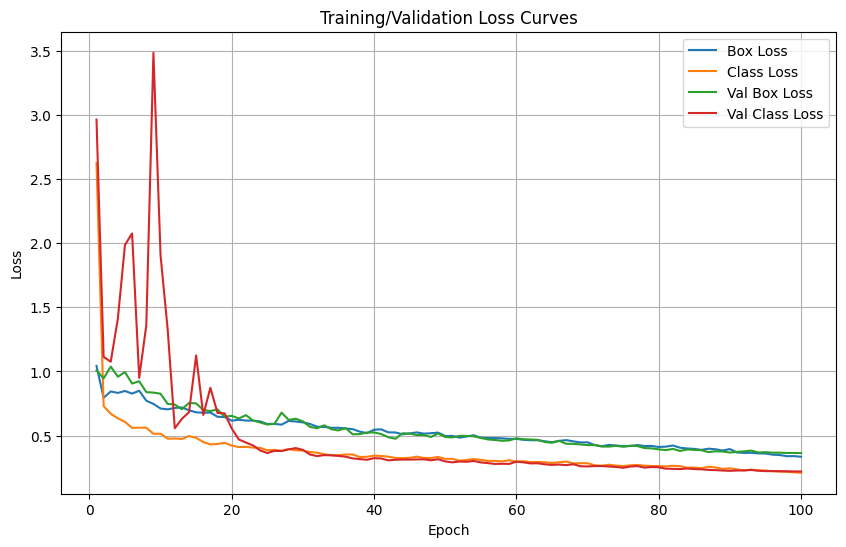

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

metrics_path = "/content/drive/MyDrive/yolo_traffic_v11/yolo11l_original18/results.csv"
df = pd.read_csv(metrics_path)

plt.figure(figsize=(10,6))
plt.plot(df['epoch'], df['train/box_loss'], label='Box Loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='Class Loss')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training/Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


# mAP50 & mAP50-90

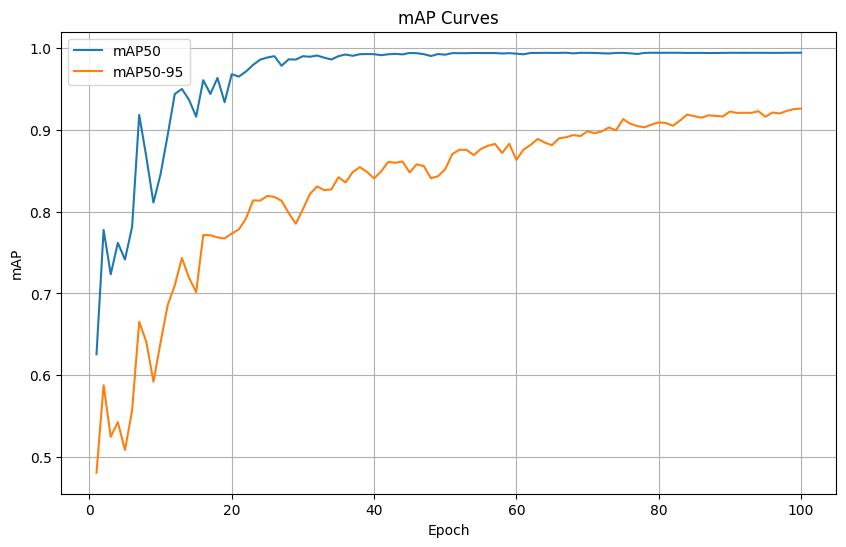

In [ ]:
df = pd.read_csv(metrics_path)
plt.figure(figsize=(10,6))
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP50-95')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('mAP Curves')
plt.legend()
plt.grid(True)
plt.show()

#F1 Score curve

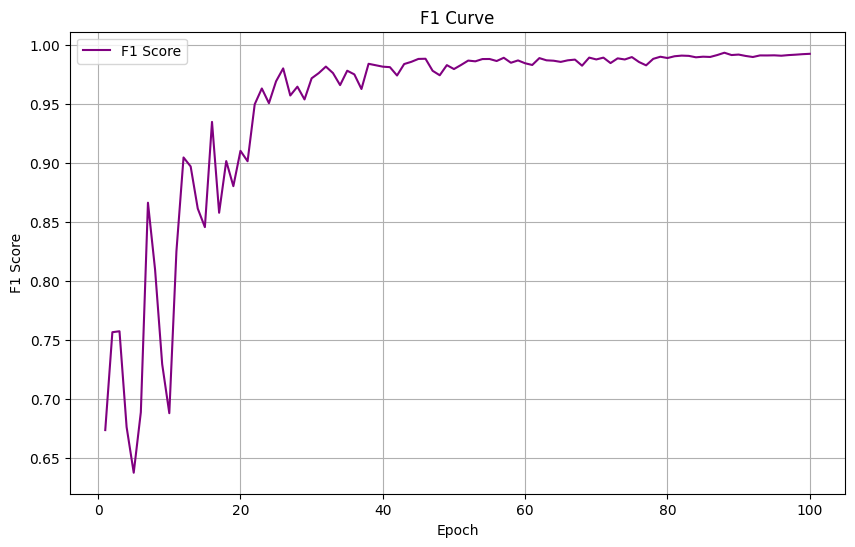

In [ ]:
plt.figure(figsize=(10,6))
f1 = 2 * (df['metrics/precision(B)'] * df['metrics/recall(B)']) / (df['metrics/precision(B)'] + df['metrics/recall(B)'])
plt.plot(df['epoch'], f1, label='F1 Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Curve')
plt.legend()
plt.grid(True)
plt.show()


#Objectness Loss Curve

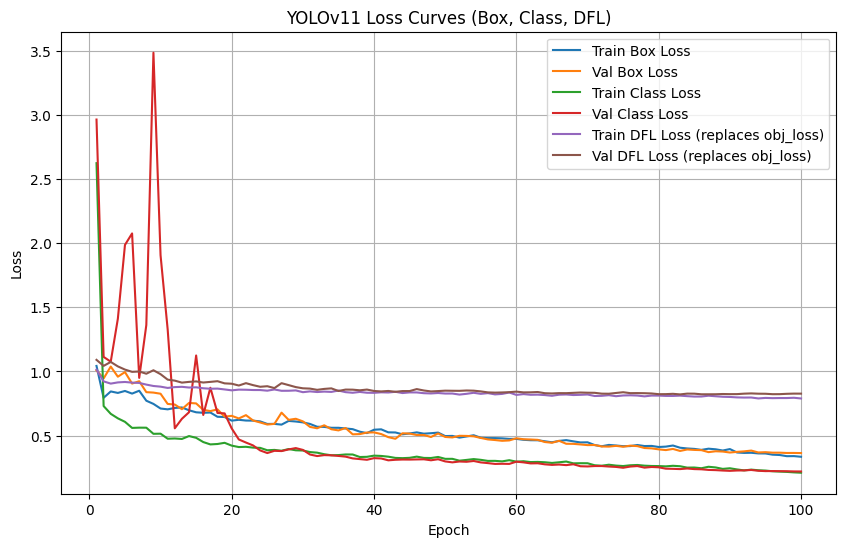

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')

plt.plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss')

plt.plot(df['epoch'], df['train/dfl_loss'], label='Train DFL Loss (replaces obj_loss)')
plt.plot(df['epoch'], df['val/dfl_loss'], label='Val DFL Loss (replaces obj_loss)')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('YOLOv11 Loss Curves (Box, Class, DFL)')
plt.legend()
plt.grid(True)
plt.show()


# Result Overall

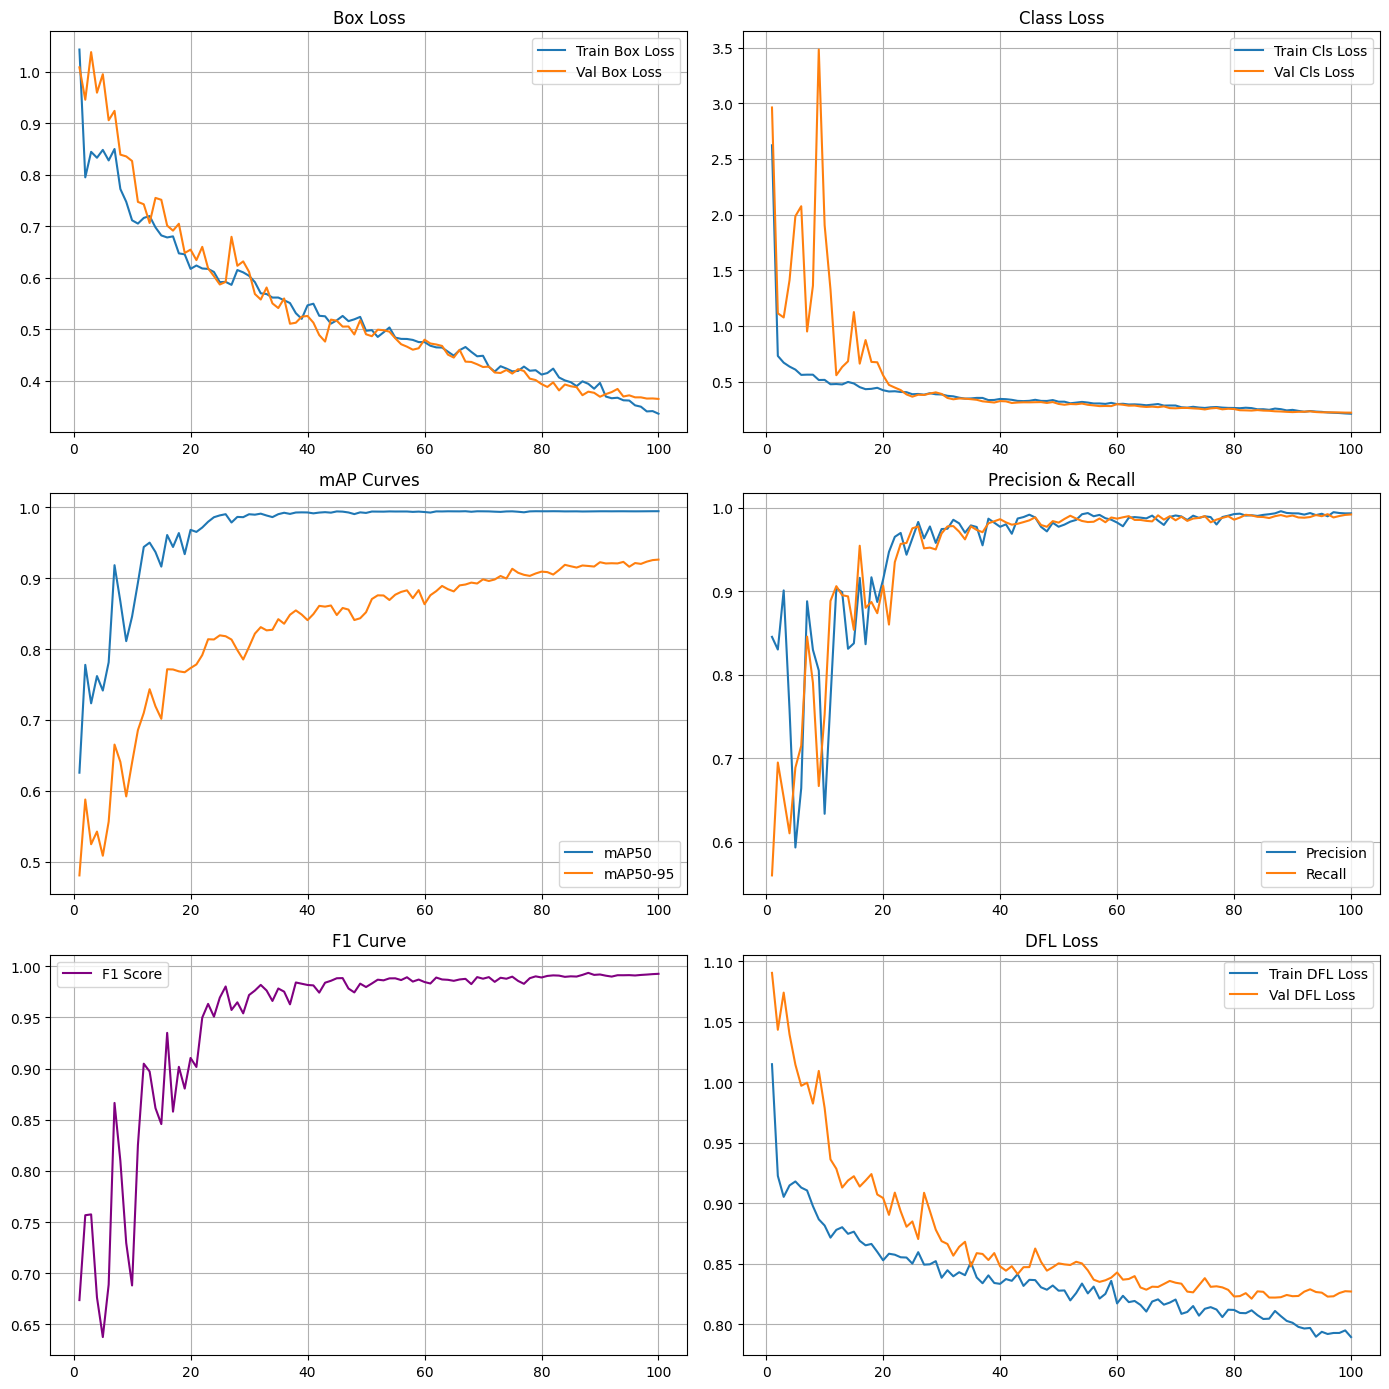

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(14, 14))

axes[0,0].plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
axes[0,0].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
axes[0,0].set_title('Box Loss'); axes[0,0].legend(); axes[0,0].grid()

axes[0,1].plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss')
axes[0,1].plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss')
axes[0,1].set_title('Class Loss'); axes[0,1].legend(); axes[0,1].grid()

axes[1,0].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50')
axes[1,0].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP50-95')
axes[1,0].set_title('mAP Curves'); axes[1,0].legend(); axes[1,0].grid()

axes[1,1].plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
axes[1,1].plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
axes[1,1].set_title('Precision & Recall'); axes[1,1].legend(); axes[1,1].grid()

f1 = 2 * (df['metrics/precision(B)'] * df['metrics/recall(B)']) / (df['metrics/precision(B)'] + df['metrics/recall(B)'])
axes[2,0].plot(df['epoch'], f1, label='F1 Score', color='purple')
axes[2,0].set_title('F1 Curve'); axes[2,0].legend(); axes[2,0].grid()

axes[2,1].plot(df['epoch'], df['train/dfl_loss'], label='Train DFL Loss')
axes[2,1].plot(df['epoch'], df['val/dfl_loss'], label='Val DFL Loss')
axes[2,1].set_title('DFL Loss'); axes[2,1].legend(); axes[2,1].grid()


plt.tight_layout()
plt.show()

#Save the best model

In [ ]:
!yolo val model=/content/drive/MyDrive/yolo_traffic_v11/yolo11l_original9/weights/best.pt, data=/content/drive/MyDrive/multi_traffic_dataset/multi_view_traffic/test_100/data_test.yaml,imgsz=640 plots=True